In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='ticks',
        color_codes=True, rc={'legend.frameon': False})

%matplotlib inline

In [8]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [10]:
from tensorflow.keras import layers

from bert.dataset import create_masked_input_dataset
from bert.layers import (PositionEmbedding, Attention, Transformer, TokenEmbedding, Bias,
                         gelu, masked_sparse_categorical_crossentropy, ECE,
                         initializer, Projection)

In [11]:
vocab_size = 22
max_seq_len = 1024
batchSize = 10

def encode(line_tensor):
    line = line_tensor.numpy().decode('utf8')

    if len(line) > max_seq_len:
        offset = np.random.randint(
            low=0, high=len(line) - max_seq_len + 1)
        line = line[offset:(offset + max_seq_len)]

    vocab = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K',
             'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 
             'W', 'Y']

    replacement_dict = {key: i + 2 for i, key in enumerate(vocab)}
    return np.asarray([replacement_dict[item] for item in line])

def encode_tf(line_tensor):
    return tf.py_function(encode, inp=[line_tensor], Tout=[tf.int32,])

training_data = create_masked_input_dataset(
    encode_fn=encode_tf,
    sequence_path='/projects/bpms/pstjohn/uniparc/sequences_train.txt',
    max_sequence_length=max_seq_len,
    batch_size=batchSize,
    buffer_size=1024,
    vocab_size=vocab_size,
    mask_index=1,
    vocab_start=2,
    fix_sequence_length=True)

training_data.repeat().prefetch(tf.data.experimental.AUTOTUNE)

valid_data = create_masked_input_dataset(
    encode_fn=encode_tf,
    sequence_path='/projects/bpms/pstjohn/uniparc/sequences_valid.txt',
    max_sequence_length=max_seq_len,
    batch_size=batchSize,
    buffer_size=1024,
    vocab_size=vocab_size,
    mask_index=1,
    vocab_start=2,
    fix_sequence_length=True)

valid_data.repeat().prefetch(tf.data.experimental.AUTOTUNE)

<PrefetchDataset shapes: ((None, 1024), (None, 1024)), types: (tf.int32, tf.int32)>

In [12]:
masked_seqs, true_values = next(iter(valid_data))

In [13]:
masked_seqs[true_values != 0]

<tf.Tensor: id=36558, shape=(512,), dtype=int32, numpy=
array([14, 17, 12,  1,  1,  1,  1,  1,  1,  1,  1,  1, 21,  1,  1,  1,  1,
        1,  5,  1,  1,  1,  1,  2,  1,  1,  1,  1,  1,  1,  9,  1,  1,  1,
        1, 15,  1,  1, 10,  1, 19, 10,  1,  1,  1,  1,  1, 19,  1,  1,  1,
       14, 11,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, 11,  1, 15,  1,
        1,  1,  1,  1,  1,  1,  1,  1, 18,  1, 13,  1,  1,  1,  1,  1,  1,
        1,  9, 14, 18,  1, 14,  1,  1,  1,  1, 11,  1,  7,  1,  1, 19,  3,
        1, 13,  1,  1,  1,  4,  1,  1,  1,  1,  4,  1,  6,  1, 15,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1, 16,  1,  1,  1,  2,  1,  1,  4,  1,
        1,  1, 16,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  5,  8,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  7,  1,  4,
        1,  1,  1,  1,  1,  1,  2,  1,  1,  1,  1,  1,  1,  1, 15,  1,  1,
        1,  1, 11,  1,  1,  1,  1,  1,  1,  

In [14]:
true_values.shape

TensorShape([10, 1024])

## BERT layers

In [15]:
embedding_dimension = 128
model_dimension = 128
transformer_dimension = 4 * model_dimension
num_attention_heads = model_dimension // 64
num_transformer_layers = 1

dropout_rate = 0.

inputs = layers.Input(shape=(max_seq_len,), dtype=tf.int32, batch_size=None)

token_embedding_layer = TokenEmbedding(
    vocab_size, embedding_dimension, embeddings_initializer=initializer(), mask_zero=True)
token_embeddings = token_embedding_layer(inputs)
position_embeddings = PositionEmbedding(
    max_seq_len + 1, embedding_dimension, embeddings_initializer=initializer(),
    mask_zero=True)(inputs)

embeddings = layers.Add()([token_embeddings, position_embeddings])
# embeddings = Projection(model_dimension, use_residual=False)(embeddings)

transformer = Transformer(num_attention_heads, transformer_dimension, dropout=dropout_rate)
for i in range(num_transformer_layers):
    embeddings = transformer(embeddings)

out = layers.Dense(embedding_dimension, activation=gelu, kernel_initializer=initializer())(embeddings)
out = token_embedding_layer(out, transpose=True)
out = Bias()(out)
#out = layers.Softmax()(out)

model = tf.keras.Model(inputs, out, name='model')
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1024)]       0                                            
__________________________________________________________________________________________________
token_embedding (TokenEmbedding multiple             2816        input_1[0][0]                    
                                                                 dense[0][0]                      
__________________________________________________________________________________________________
position_embedding (PositionEmb (None, None, 128)    131200      input_1[0][0]                    
__________________________________________________________________________________________________
add (Add)                       (None, 1024, 128)    0           token_embedding[0][0]        

In [16]:
model(masked_seqs).shape

TensorShape([10, 1024, 22])

In [17]:
from tensorflow.keras.callbacks import Callback
import tensorflow.keras.backend as K
# from tensorflow.python.framework import ops
# from tensorflow.python.ops import math_ops
# from tensorflow.keras.optimizers.schedules import LearningRateSchedule

class InverseSquareRootSchedule(Callback):
    def __init__(self, 
                 learning_rate=1E-4,
                 warmup_updates=16000):
        """ Implements the linear learning rate warmup and linear learning rate
        decay used by google in BERT pretraining """
        
        self.learning_rate = learning_rate
        self.warmup_updates = warmup_updates
        self.decay_factor = learning_rate * warmup_updates**0.5
        self._hist = []
        
    def on_epoch_begin(self, epoch, logs=None):
        self.current_epoch = epoch
        
    def on_train_batch_begin(self, batch, logs=None):
        
        global_step = (
            batch + self.current_epoch * self.params['steps'])
        
        # Still in warmup
        if global_step <= self.warmup_updates:
            scheduled_lr = self.learning_rate * (
                global_step / self.warmup_updates)
        
        # Linear decay
        else:
            scheduled_lr = self.decay_factor * global_step**(-0.5)
            
        self._hist += [(global_step, scheduled_lr)]
            
        K.set_value(self.model.optimizer.lr, scheduled_lr)

In [18]:
learning_rate = 1E-3
warmup_updates = 300

# Horovod: add Horovod DistributedOptimizer.
opt = tf.optimizers.Adam(learning_rate=learning_rate)

true_labels = layers.Input(shape=(None,), dtype=tf.int32, batch_size=None)
model.compile(
    loss=masked_sparse_categorical_crossentropy,
    metrics=[ECE],
    target_tensors=true_labels,
    experimental_run_tf_function=False,
    optimizer=opt)

callbacks = [
    InverseSquareRootSchedule(learning_rate=learning_rate,
                              warmup_updates=warmup_updates)
]

In [19]:
model.fit(training_data, steps_per_epoch=1000, epochs=3, verbose=1,
          validation_data=valid_data, validation_steps=10, callbacks=callbacks)

Epoch 1/3


/home/pstjohn/miniconda3/envs/tf2/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


1000/1000 [==============================] - 30s 30ms/step - loss: 2.7395 - ECE: 15.5797 - val_loss: 2.6809 - val_ECE: 14.6183
Epoch 2/3
1000/1000 [==============================] - 26s 26ms/step - loss: 2.6735 - ECE: 14.5073 - val_loss: 2.6722 - val_ECE: 14.5007
Epoch 3/3
1000/1000 [==============================] - 26s 26ms/step - loss: 2.6685 - ECE: 14.4372 - val_loss: 2.6837 - val_ECE: 14.6462


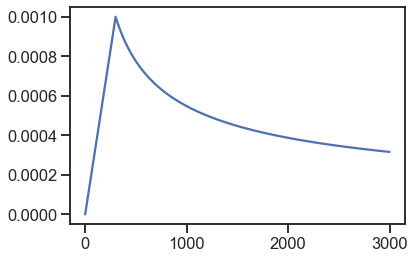

In [22]:
lrs = np.array(callbacks[0]._hist)
plt.plot(lrs[:, 0], lrs[:, 1])

In [ ]:
model.evaluate(valid_data, steps=10)

In [ ]:
model.save('test_model.h5')

In [24]:
model = tf.keras.models.load_model(
    '/scratch/pstjohn/albert_single_aa_debug_checkpoints/ckpt_1.h5',
    custom_objects={
        'PositionEmbedding': PositionEmbedding,
        'TokenEmbedding': TokenEmbedding,
        'Attention': Attention,
        'Transformer': Transformer,
        'Projection': Projection,        
        'Bias': Bias,
        'gelu': gelu,
        'masked_sparse_categorical_crossentropy': masked_sparse_categorical_crossentropy,
        'ECE': ECE,
        'InverseSquareRootSchedule': InverseSquareRootSchedule,
    })

# true_labels = layers.Input(shape=(None,), dtype=tf.int32, batch_size=None)
# model.compile(loss=masked_sparse_cross_entropy_loss, target_tensors=true_labels,
#               optimizer=tfa.optimizers.AdamW(weight_decay=0.01, learning_rate=1E-3))

/home/pstjohn/miniconda3/envs/tf2/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [25]:
model.evaluate(valid_data, steps=10)

10/10 [==============================] - 9s 880ms/step - loss: 2.6666 - ECE: 14.3983


[2.666582942008972, 14.398306]

In [26]:
model.fit(training_data, steps_per_epoch=100, epochs=3, verbose=1,
          validation_data=valid_data, validation_steps=10)

Train for 100 steps, validate for 10 steps
Epoch 1/3


/home/pstjohn/miniconda3/envs/tf2/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


  6/100 [>.............................] - ETA: 4:42 - loss: 2.6722 - ECE: 14.4775

KeyboardInterrupt: 

In [ ]:
# eval_data = valid_data.map(sp_encode_tf, num_parallel_calls=tf.data.experimental.AUTOTUNE).padded_batch(60, padded_shapes=([512],))
# eval_encoded = next(iter(eval_data))

In [ ]:
bert_predict = model.predict(encoded_data.take(3), verbose=1)

In [ ]:
bert_predict.shape